In [1]:

import sys
# CPU-only build (fastest to get started, works everywhere)
!{sys.executable} -m pip install torch --index-url https://download.pytorch.org/whl/cpu


Looking in indexes: https://download.pytorch.org/whl/cpu


In [2]:
import sys
!{sys.executable} -m pip install yfinance


In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

In [4]:
device = torch.device('cpu')

In [5]:
ticker = 'AAPL'
df = yf.download(ticker, '2020-01-01')
display(df.head(10))

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.468277,72.528597,71.223274,71.476615,135480400
2020-01-03,71.763718,72.523746,71.539330,71.696160,146322800
2020-01-06,72.335548,72.374154,70.634532,70.885464,118387200
2020-01-07,71.995354,72.600960,71.775789,72.345204,108872000
2020-01-08,73.153488,73.455087,71.698574,71.698574,132079200
2020-01-09,74.707329,74.900349,73.879742,74.130668,170108400
2020-01-10,74.876228,75.440829,74.374370,74.941378,140644800
2020-01-13,76.475906,76.502451,75.074074,75.192306,121532000


<Axes: xlabel='Date'>

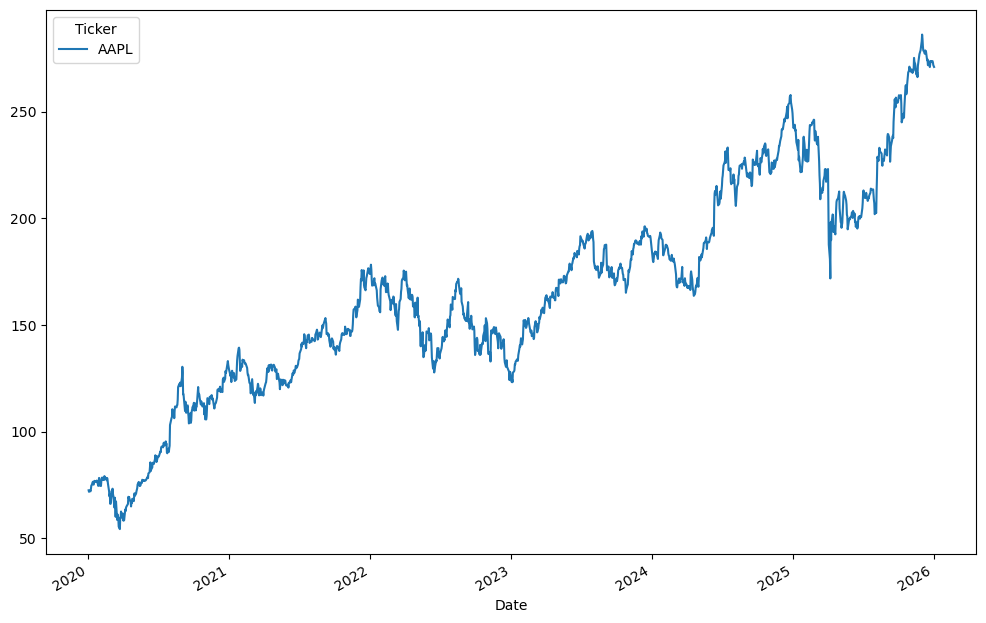

In [13]:
df.Close.plot(figsize = (12, 8))

In [15]:
scaler = StandardScaler()
# scale the closing data for our model to a normal distribution around 1
df['Close'] = scaler.fit_transform(df['Close']) 

SyntaxError: invalid syntax (144803186.py, line 2)

In [25]:
df['Close'].head()

Ticker,AAPL
Date,
2020-01-02,-1.859777
2020-01-03,-1.873936
2020-01-06,-1.862444
2020-01-07,-1.869281
2020-01-08,-1.846007


In [ ]:
#clarify the data for our neural network
#give a data range so our model can predict the closing price for the next day
seq_length = 31
data = []
for i in range(len(df) - seq_length): 
    # evaluate along the model in 30-day blocks
    #attempting to predict the value of the 31st day
    data.append(df.Close[i:i + seq_length])
data = np.array(data)
train_size = int(0.8*len(data))

X_train = torch.from_numpy(data[:train_size, :-1 :])